In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot

# Load the dataset
# def get_dataset():
#     data = pd.read_csv('data/cleveland.csv')
#     X = data.drop('num', axis=1)
#     y = data['num'].apply(lambda x: 1 if x > 0 else 0)  # Binary classification: 0 = no disease, 1 = disease
    
#     # Handle missing values
#     X = X.replace('?', np.nan).astype(float)
#     X = X.fillna(X.mean())
    
#     # Normalize the features
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)
    
#     return X, y.values
def get_dataset():
    data = pd.read_csv('data/cleveland.csv')
    X = data.drop('num', axis=1)
    y = data['num'].apply(lambda x: 1 if x > 0 else 0)
    
    X = X.replace('?', np.nan).astype(float)
    X = X.fillna(X.mean())
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X, y.values

def feature_selection(X, selected_features):
    return X[selected_features]

Ideal: 0.832
> folds=2, accuracy=0.832 (0.808,0.855)
> folds=3, accuracy=0.845 (0.832,0.871)
> folds=4, accuracy=0.825 (0.776,0.868)
> folds=5, accuracy=0.825 (0.717,0.885)
> folds=6, accuracy=0.835 (0.720,0.902)
> folds=7, accuracy=0.828 (0.744,0.909)
> folds=8, accuracy=0.832 (0.711,0.868)
> folds=9, accuracy=0.835 (0.697,0.941)
> folds=10, accuracy=0.825 (0.633,0.935)
> folds=11, accuracy=0.831 (0.630,0.963)
> folds=12, accuracy=0.835 (0.720,0.920)
> folds=13, accuracy=0.828 (0.696,0.958)
> folds=14, accuracy=0.828 (0.667,0.955)
> folds=15, accuracy=0.832 (0.600,0.950)
> folds=16, accuracy=0.835 (0.684,0.947)
> folds=17, accuracy=0.832 (0.667,1.000)
> folds=18, accuracy=0.832 (0.647,0.941)
> folds=19, accuracy=0.829 (0.688,0.938)
> folds=20, accuracy=0.835 (0.667,0.933)


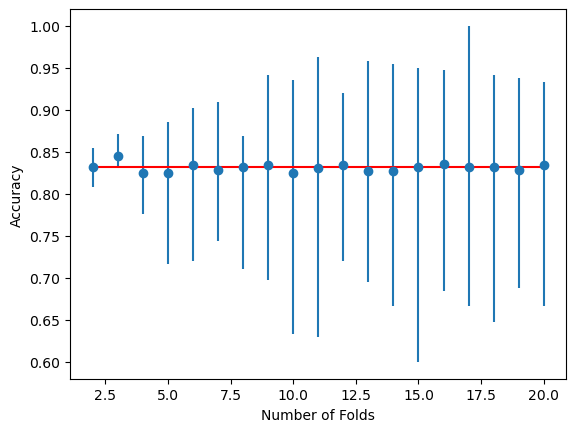

In [28]:
# Retrieve the model
def get_model():
    return LogisticRegression(max_iter=1000)

# def evaluate_model(cv):
#     X, y = get_dataset()
#     model = get_model()
#     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#     return np.mean(scores), scores.min(), scores.max()

def evaluate_model(X, y, cv):
    model = get_model()
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return np.mean(scores), scores.min(), scores.max()

X, y = get_dataset()

ideal_features = ['cp', 'slope', 'chol', 'age', 'restecg', 'sex', 'fbs', 'exang']
X_selected = feature_selection(X, ideal_features)

# Evaluate using leave-one-out cross-validation
# ideal, _, _ = evaluate_model(X_selected, y, LeaveOneOut())
ideal, _, _ = evaluate_model(X, y, LeaveOneOut())
print('Ideal: %.3f' % ideal)

# Define folds to test, test from 2 to 20 folds
folds = range(2, 21)

# Perform k-fold cross-validation analysis
means, mins, maxs = [], [], []

for k in folds:
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    k_mean, k_min, k_max = evaluate_model(X, y, cv)
    print(f'> folds={k}, accuracy={k_mean:.3f} ({k_min:.3f},{k_max:.3f})')
    means.append(k_mean)
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)


# Line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
pyplot.xlabel('Number of Folds')
pyplot.ylabel('Accuracy')
pyplot.show()

In [ ]:
# TODO: Will need to perform feature selection


In [ ]:
# Example from https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

# sensitivity analysis of k in k-fold cross-validation
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# create the dataset
def get_dataset(n_samples=100):
	X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y

# retrieve the model to be evaluate
def get_model():
	model = LogisticRegression()
	return model

# evaluate the model using a given test condition
def evaluate_model(cv):
	# get the dataset
	X, y = get_dataset()
	# get the model
	model = get_model()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,31)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
	# define the test condition
	cv = KFold(n_splits=k, shuffle=True, random_state=1)
	# evaluate k value
	k_mean, k_min, k_max = evaluate_model(cv)
	# report performance
	print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
	# store mean accuracy
	means.append(k_mean)
	# store min and max relative to the mean
	mins.append(k_mean - k_min)
	maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
pyplot.show()